In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import random_split, Dataset, DataLoader, Subset
from torchvision.transforms import v2
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights

from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

from huggingface_hub import hf_hub_download

In [2]:
TRAIN_PATH = '/home/khoa/PersonalProject/BRAIN_PROJECT/Training'
TEST_PATH = '/home/khoa/PersonalProject/BRAIN_PROJECT/Testing'

BATCH_SIZE = 16
LR = 0.001
NUM_WORKERS = 4
EPOCHS = 10
PATIENCE = 5

In [3]:
train_transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomRotation(degrees=(0, 180)),
    v2.RandomHorizontalFlip(1.0),
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    v2.RandomResizedCrop((256, 256), scale=(0.5, 1.0)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.Resize((256, 256))
])

test_transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.Resize((256, 256))
])

In [4]:
class BrainDataset(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.transform = transform
        self.images = []
        self.labels = []
        self.encode_label = {'glioma':0, 'meningioma':1, 'notumor':2, 'pituitary':3}

        for label in sorted(os.listdir(path)):
            for img_path in sorted(os.listdir(os.path.join(path, label))):
                image = Image.open(os.path.join(path, label, img_path)).convert('RGB')
                self.images.append(image)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.transform(self.images[index]), torch.Tensor([self.encode_label[self.labels[index]]]).to(torch.long).squeeze()

In [5]:
train_val_dataset = BrainDataset(TRAIN_PATH, train_transform)
test_dataset = BrainDataset(TEST_PATH, test_transform)

train_dataset, val_dataset = random_split(train_val_dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(len(train_dataset), len(val_dataset), len(test_dataset))

5141 571 1311


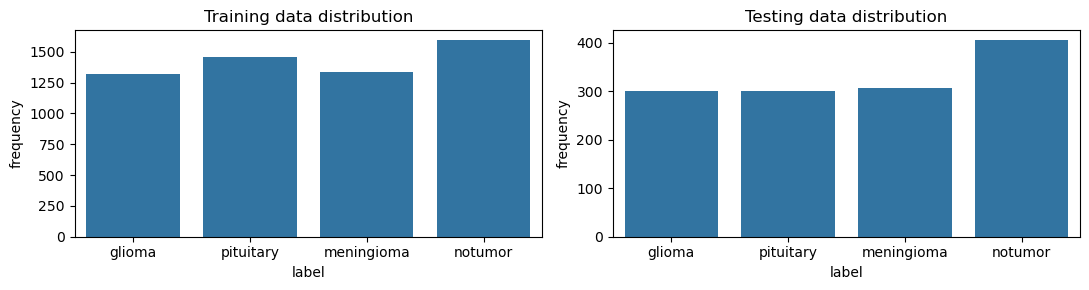

In [6]:
train_plot = {}
test_plot = {}

for label in os.listdir(TRAIN_PATH):
    train_plot[label] = len(os.listdir((os.path.join(TRAIN_PATH, label))))

for label in os.listdir(TEST_PATH):
    test_plot[label] = len(os.listdir((os.path.join(TEST_PATH, label))))

fig, axes = plt.subplots(1, 2, figsize=(11, 3))

axes[0].set_title('Training data distribution')
axes[1].set_title('Testing data distribution')

for i in range(2):
    axes[i].set_xlabel('label')
    axes[i].set_ylabel('frequency')

sns.barplot(train_plot, ax=axes[0])
sns.barplot(test_plot, ax=axes[1])
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.868191..2.1449604].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4445693].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.140534].


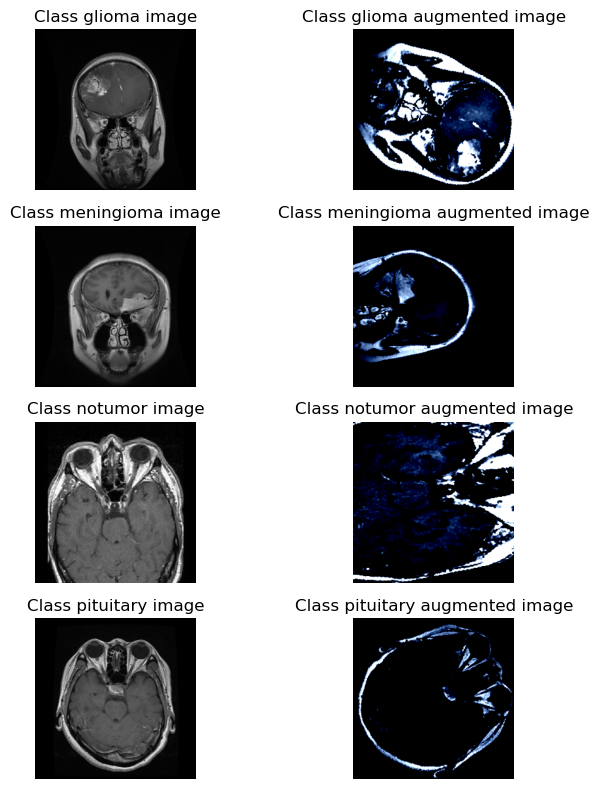

In [7]:
fig = plt.figure(figsize=(8, 8))
paths = []

for label in sorted(os.listdir(TRAIN_PATH)):
    paths.append(os.path.join(TRAIN_PATH, label, sorted(os.listdir(os.path.join(TRAIN_PATH, label)))[0]))


j = 0
ax = []
labels = [label for label in sorted(os.listdir(TRAIN_PATH))]

for i in range(1, 9, 2):

    image = Image.open(paths[j]).convert('RGB').resize((256, 256))

    ax.append(fig.add_subplot(4, 2, i))
    ax[-1].set_title(f'Class {labels[j]} image')
    plt.axis('off')
    plt.imshow(image)

    a = i + 1

    ax.append(fig.add_subplot(4, 2, a))
    ax[-1].set_title(f'Class {labels[j]} augmented image')
    plt.axis('off')
    plt.imshow(train_transform(image).permute(1, 2, 0))

    j += 1


plt.tight_layout()
plt.show()


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
class Classifier(nn.Module):
    def __init__(self, n_output_class):
        super().__init__()
        self.dropout = nn.Dropout()
        self.linear = nn.Linear(2048, n_output_class)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x

class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = resnet50(pretrained=False)
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:9])
    
    def forward(self, x):
        x = self.backbone(x)
        return x

In [10]:
backbone = Backbone()
classifier = Classifier(4)

model_path = hf_hub_download(repo_id="Lab-Rasool/RadImageNet", filename="ResNet50.pt")

backbone.load_state_dict(torch.load(model_path))
model = nn.Sequential(backbone, classifier)
model = model.to(device)

/home/khoa/anaconda3/envs/ds-ai-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khoa/anaconda3/envs/ds-ai-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_20885/1135060657.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only`

In [13]:
loss_function = CrossEntropyLoss()
optimizer = optimizer = optim.AdamW(model.parameters(), lr=LR)

# scheduler = lr_scheduler.CyclicLR(optimizer, 
#                                   base_lr=0.001, 
#                                   max_lr=0.006, 
#                                   mode='triangular2', 
#                                   step_size_up=3)

In [11]:
BEST_MODEL_PATH = f'/home/khoa/PersonalProject/BRAIN_PROJECT/best_model_{model._get_name()}.pth'

In [14]:
best_acc = 0.0
epoch_no_improve = 0

for epoch in range(EPOCHS):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0

    n_corrects_train = 0.0
    n_samples_train = 0.0

    n_corrects_val = 0.0
    n_samples_val = 0.0

    model.train()
    for index, (images, labels) in enumerate(train_data_loader):

        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        predicts = model(images)
        loss = loss_function(predicts, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predicts, 1)
        train_loss += loss.item()
        n_corrects_train += (predicted == labels).sum().item()
        n_samples_train += labels.size(0)
        
    train_loss /= len(train_data_loader)
    train_acc = 100 * n_corrects_train / n_samples_train
    
    #scheduler.step()

    model.eval()
    with torch.no_grad():
        for index, (images, labels) in enumerate(val_data_loader):

            images = images.to(device)
            labels = labels.to(device)
            predicts = model(images)
            loss = loss_function(predicts, labels)

            val_loss += loss.item()
            _, predicted = torch.max(predicts, 1)
            n_corrects_val += (predicted == labels).sum().item()
            n_samples_val += labels.size(0)
        
    val_loss /= len(val_data_loader)
    val_acc = 100 * n_corrects_val / n_samples_val

    print(f'Epoch [{epoch+1}/{EPOCHS}]:')
    print(f'train_acc: {train_acc:.4f}%')
    print(f'train_loss: {train_loss:.4f}')
    print(f'val_acc: {val_acc:.4f}%')
    print(f'val_loss: {val_loss:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        epoch_no_improve += 1
    if epoch_no_improve > PATIENCE:
        print('Early stopping!')
        break

print('Training done!')

Epoch [1/10]:
train_acc: 76.2887%
train_loss: 0.5885
val_acc: 91.2434%
val_loss: 0.2394
Epoch [2/10]:
train_acc: 89.8074%
train_loss: 0.2958
val_acc: 94.7461%
val_loss: 0.1695
Epoch [3/10]:
train_acc: 91.5775%
train_loss: 0.2408
val_acc: 93.3450%
val_loss: 0.2052
Epoch [4/10]:
train_acc: 93.6977%
train_loss: 0.1916
val_acc: 93.6953%
val_loss: 0.1859
Epoch [5/10]:
train_acc: 94.4369%
train_loss: 0.1744
val_acc: 92.6445%
val_loss: 0.2404
Epoch [6/10]:
train_acc: 93.9700%
train_loss: 0.1794
val_acc: 94.3958%
val_loss: 0.1670
Epoch [7/10]:
train_acc: 95.1955%
train_loss: 0.1422
val_acc: 95.9720%
val_loss: 0.1255
Epoch [8/10]:
train_acc: 95.8374%
train_loss: 0.1215
val_acc: 94.2207%
val_loss: 0.1699
Epoch [9/10]:
train_acc: 95.2538%
train_loss: 0.1391
val_acc: 94.9212%
val_loss: 0.1271
Early stopping!
Training done!


In [15]:
corrects = [0 for _ in range(4)]
samples = [0 for _ in range(4)]
y_true = []
y_pred = []

encode_label = {0:'glioma', 1:'meningioma', 2:'notumor', 3:'pituitary'}

model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
model.eval()
with torch.no_grad():
    for index, (images, labels) in enumerate(test_data_loader):

        images = images.to(device)
        labels = labels.to(device)
        predicts = model(images)
        _, predicted = torch.max(predicts, 1)

        for i in range(labels.size(0)):
            predict = predicted[i]
            label = labels[i]
            if label == predict:
                corrects[label] += 1
            samples[label] += 1

            y_pred.append(encode_label[predict.item()])
            y_true.append(encode_label[label.item()])


acc_list = [100.0 * corrects[i] / samples[i] for i in range(len(samples))]

print(f'Overall accuracy: {sum(acc_list) / len(acc_list):.4f}')
for i in range(len(samples)):
    print(f'Accuracy of {encode_label[i]}: {acc_list[i]:.4f}')

Overall accuracy: 95.4884
Accuracy of glioma: 97.3333
Accuracy of meningioma: 91.8301
Accuracy of notumor: 96.7901
Accuracy of pituitary: 96.0000


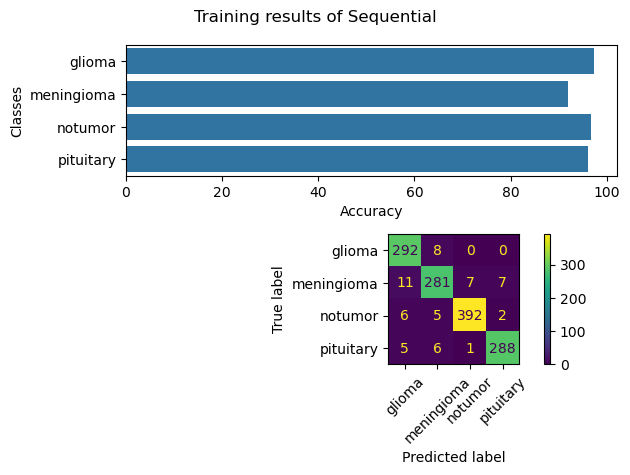

In [16]:
fig, axes = plt.subplots(2)

sns.barplot(x=[acc_list[i] for i in range(4)], y=['glioma', 'meningioma', 'notumor', 'pituitary'], ax=axes[0])
axes[0].set_xlabel('Accuracy')
axes[0].set_ylabel('Classes')

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=axes[1], xticks_rotation=45)

plt.suptitle(f'Training results of {model._get_name()}')
plt.tight_layout()
plt.show()